In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice

In [2]:
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination(n, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute(n, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a, l=0,a=0):
  
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

In [42]:
def diagonalmartrixBPPM(n):
    matrix = np.eye(math.factorial(n))
    return matrix 

def P_AB_BPPM(n, P, P_D):
    # # Calculates the sum and use it to set the diagonal elements, 
    # # which returns the distribution sum.
    # def binomial_distribution(P, n):
    #     distribution = [((1-P) ** r) * ((P) ** (n -1 - r)) for r in range(n+1)]
    #     # we do not calcualte the last term, becasue 
    #     distribution_sum = sum(distribution[:-1])
    #     return distribution_sum
    # # Generates all permutations of length n.
    # permutations = itertools.permutations(range(n))
    # num_permutations = len(list(permutations))
    # # Creates an n! x n! matrix with diagonal elements set to the distribution sum.
    # distribution_sum = binomial_distribution(P, n)
    # then we put it to the diagonal elements
    # n! x n!
    matrix = (1/math.factorial(n)) * (1-P_D) * diagonalmartrixBPPM(n) #if i == j else 0 for j in range(math.factorial(n))] for i in range(math.factorial(n))]
    return matrix

# sum over the elements in rows in the probability matrix P_AB
# renormalized in P_AB already
def P_A_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already
def P_B_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM)]
# # calculate the trace of the probability matrix P_AB
# def trace_P_AB(P_AB):
#     return sum([P_AB[i][i] for i in range(len(P_AB))])

# H_A, H_B, H_AB are the same as the trivial case
def H_A_BPPM(P_AB_BPPM):
     P_A_BPPM = np.sum(P_AB_BPPM, axis=1)
     H_a = np.sum(-P_A_BPPM * np.log2(np.where(P_A_BPPM == 0, 1, P_A_BPPM)))
     return H_a

def H_B_BPPM(P_AB_BPPM):
     P_B_BPPM = np.sum(P_AB_BPPM, axis=0)

     H_b = np.sum(-P_B_BPPM * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM)))
     return H_b

def H_AB_BPPM(P_AB_BPPM):
    P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
    H = -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()
    return H

# def I_AB(H_A, H_B, H_AB, P_D):
#   return ((H_A + H_B - H_AB))*(1-P_D)

def I_AB_BPPM(H_A_BPPM, H_B_BPPM, H_AB_BPPM, P_D):
    if np.isnan(H_AB_BPPM):
        return 0
    else:
        return ((H_A_BPPM + H_B_BPPM - H_AB_BPPM))*(1-P_D)

P_list = np.linspace(1e-6,0.999999,101)
I_AB_BPPM_list = []

for P in P_list:
  n = 5
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  I_AB_BPPM_list.append(I_AB_BPPM_val)

In [39]:
def compute_M(M):
  return M

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(n_PPM, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n_PPM))) / (math.factorial((int(n_PPM-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

def Add_Distribute_PPM(n_PPM, P_a, a):
    #M = compute_M(M)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(M - n_PPM, a) * (P_a)**a * (1 - P_a)**(M - n_PPM - a)

# define a separate function for computing the probability of error
def P_err(n_PPM, P_l, P_a,l,a):
  return Loss_Distribute(n_PPM,P_l,l) * Add_Distribute(n_PPM,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_PPM(n_PPM,P_l,P_a,l,a):
  return P_err(n_PPM,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_PPM(_PPM,P_l,P_a, l=0,a=0):
  return 1 - P_Success_PPM(n_PPM,P_l,P_a, l=0, a=0)

def diagonalmatrix(M):
    matrix = np.eye(2*M)
    return matrix

def P_AB_PPM(M, P_D_PPM):
    #M = compute_M(M) #int(len(list(itertools.permutations(range(n)))))
    # P_AB_PPM = [(P ** i) * ((1 - P) ** (n - 1 - i)) for i in range(n)]
    # P_AB_PPM = [(1-P_D_PPM) for i in range(M)]
    matrix =  diagonalmatrix(M) * 1/(2*M)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]
def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)

I_AB_PPM_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n_PPM = 1
  M = 5
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_val)

In [40]:
diagonalmatrix(2)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [41]:
P_AB_PPM(2, 1)

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

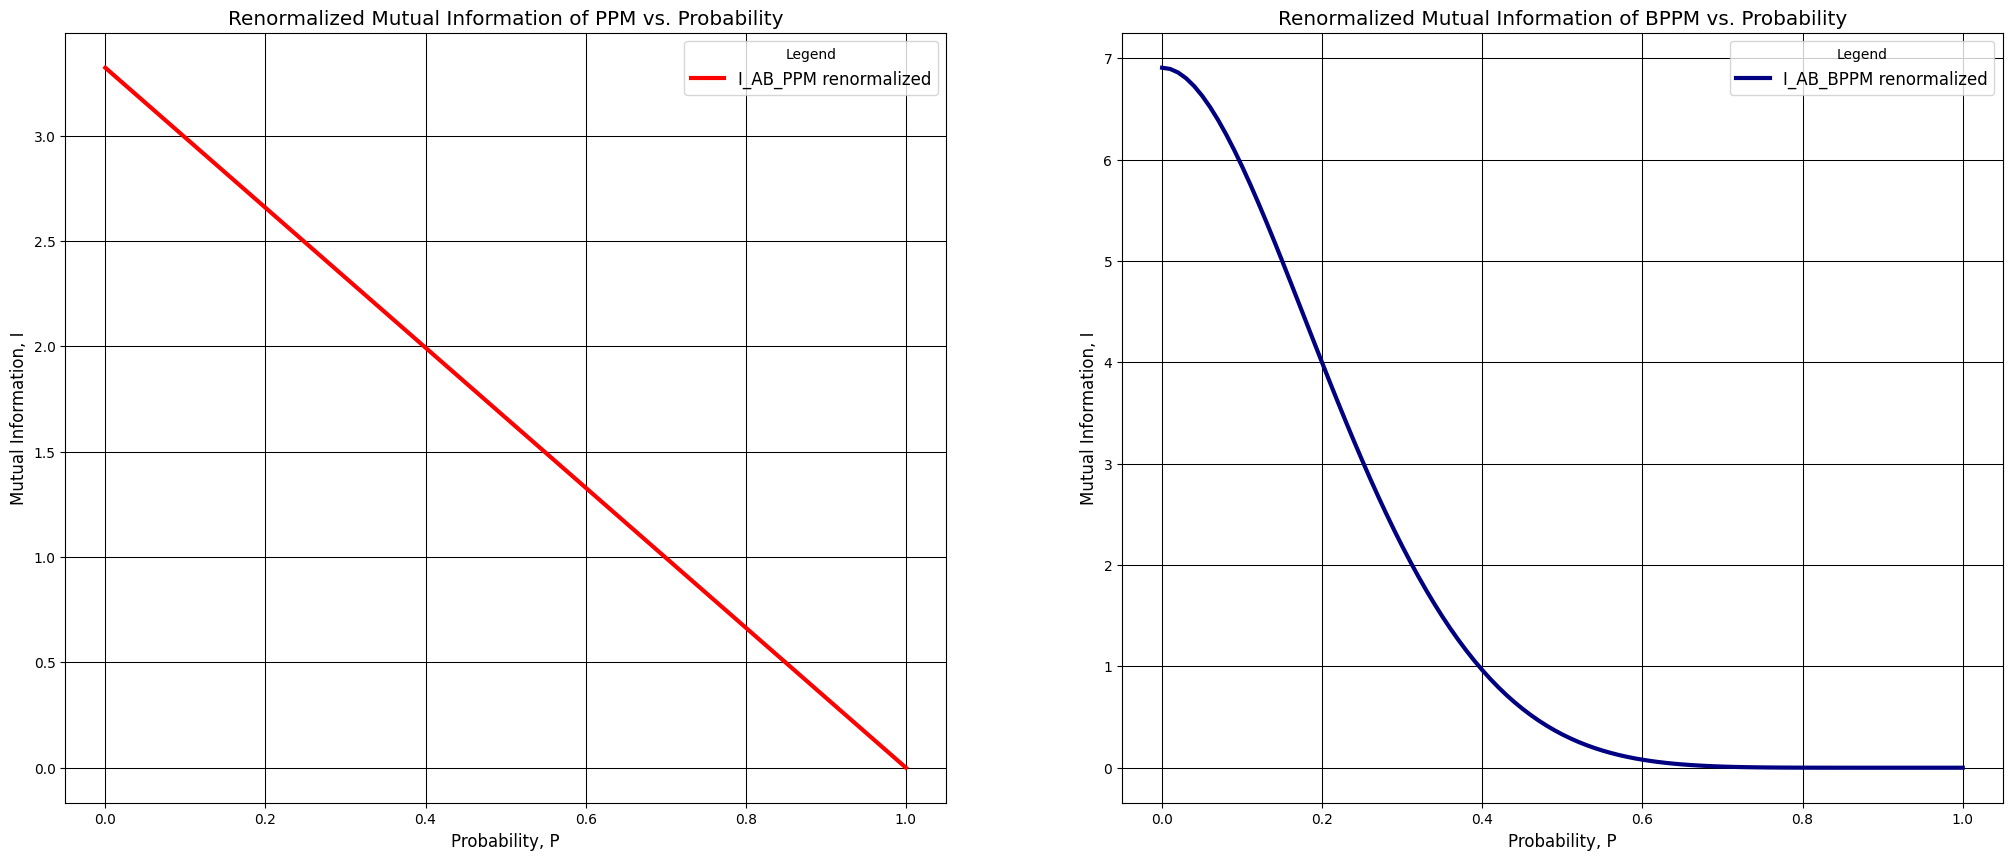

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
axs[0].plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, color='r', alpha=1)
axs[0].legend(title='Legend', loc='upper right', fontsize='large')
axs[0].grid(color='k', linestyle='-', linewidth=0.75)
axs[0].set_xlabel('Probability, P', fontsize='large')
axs[0].set_ylabel('Mutual Information, I', fontsize='large')
axs[0].set_title('Renormalized Mutual Information of PPM vs. Probability', fontsize='x-large')
axs[0].set_facecolor('white')

# plot on the right
axs[1].plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, color='navy', alpha=1)
axs[1].legend(title='Legend', loc='upper right', fontsize='large')
axs[1].grid(color='k', linestyle='-', linewidth=0.75)
axs[1].set_xlabel('Probability, P', fontsize='large')
axs[1].set_ylabel('Mutual Information, I', fontsize='large')
axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
axs[1].set_facecolor('white')

plt.show()

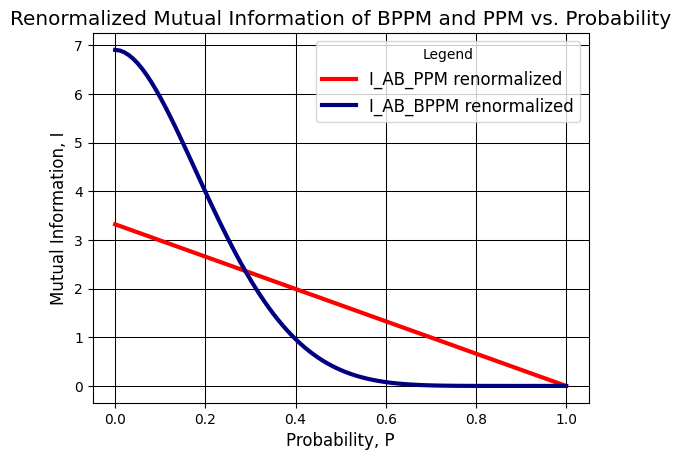

<Figure size 1500x480 with 0 Axes>

In [6]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Renormalized Mutual Information of BPPM and PPM vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

In [7]:
M

5

In [8]:
# P_D(1,P, 0, l=0,a=0)
# P_Success1(1,P,P,0,0)
combination(5 - 1, 0) * (P)**0 * (1 - P)**(5 - 1 - 0)
combination(1, 0) * (P)**0 * (1 - P)**(1 - 0)
len(P_AB_PPM(5, P_D_val))

10

In [9]:
print(len(I_AB_PPM_list), len(I_AB_PPM_list))

101 101


# General

The number of symbols m in general method will be the number of ways k photons can be placed in n bins, i.e. 

$$m= \binom{n}{k}$$

If we have 4 photons, 14 timeslots, then there will be 1,0001 ways to order them by binomial where order does not matter.

The number of bits (the information content per symbol) will be 
$$b=log_2m$$

However, if we consider the repeition are not allowed, then we use 
Permutations = r! x Combinations 

B1. Compare with "general" method using same number of slots, n, and same number of photons, k \\

B2. The number of symbols m in general method will be the number ow ways k photons can be placed in n bins, i.e. m=(n over k) \\

B3. The number of bits (the information content per symbol) will be b=log2(m)


We can use $\binom{10}{2}$ and $\binom{15}{3}$ to maintain the power $\frac{1}{5}$ for comparison

In [10]:
def compute_T_General(n_General):
  # def agen(): # generator of terms
  #     aset, sset, k = set(), set(), 0
  #     while True:
  #         k += 1
  #         while any(k+an in sset for an in aset): k += 1
  #         yield k; sset.update(k+an for an in aset); aset.add(k)
  # a = list(islice(agen(), 100))
  # photon = list(map(lambda v: v-1, a))
  # compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  T_General = M * n_General # int(len(list(itertools.permutations(range(n)))))
  
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    # return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, P_a, a):
    T_General = compute_T_General(n_General)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_General - n, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_AB_General(n_General):
    T_General =  compute_T_General(n_General)
    matrix = np.eye(int(combination(T_General, n_General))) / combination(T_General, n_General)
    #matrix = np.eye((combination(T_General, n_General))) / combination(T_General, n_General)  
    return matrix 

def P_A_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]
    
def H_A_General(P_AB_General):
     P_A_General = np.sum(P_AB_General, axis=1)
     H_a_General = np.sum(-P_A_General * np.log2(np.where(P_A_General == 0, 1, P_A_General)))
     return H_a_General

def H_B_General(P_AB_General):
     P_B_General = np.sum(P_AB_General, axis=0)
     H_b_General = np.sum(-P_B_General * np.log2(np.where(P_B_General == 0, 1, P_B_General)))
     return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General = np.where(P_AB_General == 0, 1e-9, P_AB_General)  # replace zero values with 1e-9
    H_General = -(P_AB_General * np.log2(P_AB_General)).sum()
    return H_General

def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General)

In [11]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n2_list.append(I_AB_General_val)
    
    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n3_list.append(I_AB_General_val)




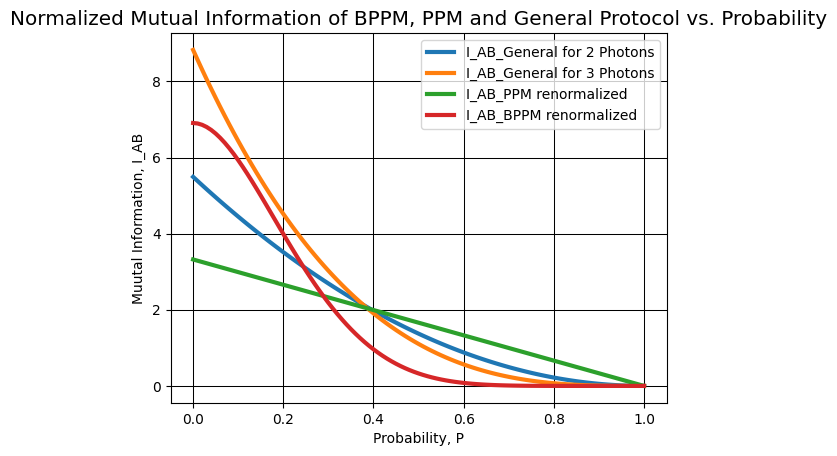

In [12]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Why all these protocols have the same power and they meet at (0.4, 2) except BPPM? 

power ratio: number of photon / time bin



# Note 
Same Power but different number of photon
 
High number of photon then have higher mutual information
it also has a longer block
we are not normalizing over the block length
mututal information for different block
n = 2,  T = 10
n = 3 , T = 15, it should have more information, which is not strange 

BPPM
n = 5, T = 26
It may be due to diferent ways of ordering in permutation

## Mutual Informatioln per Time Bin at Constant Power

In [13]:
I_AB_BPPM_per_Time_Bin_list = []
I_AB_PPM_per_Time_Bin_list = []
I_AB_General_n2_per_Time_Bin_list = []
I_AB_General_n3_per_Time_Bin_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
    n = 5
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_per_Timebin_val = I_AB_BPPM_val/N_n
    I_AB_BPPM_per_Time_Bin_list.append(I_AB_BPPM_per_Timebin_val)


    n_PPM = 1
    M = 5

    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_per_timebin_val = I_AB_PPM_val / M
    I_AB_PPM_per_Time_Bin_list.append(I_AB_PPM_per_timebin_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    I_AB_General_n2_per_Time_Bin_list.append(I_AB_General_per_timebin_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    I_AB_General_n3_per_Time_Bin_list.append(I_AB_General_per_timebin_val)

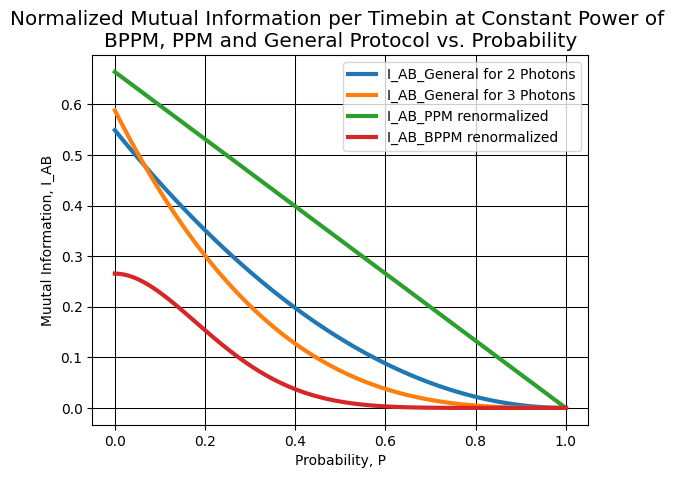

In [14]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_per_Time_Bin_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_per_Time_Bin_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_per_Time_Bin_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_per_Time_Bin_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information per Timebin at Constant Power of \nBPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
# plt.title('I_AB_General for n_General = 2 and n_General = 3\nwith a long title that spans two lines')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [15]:
combination(T_General, n_General)

455.0

In [16]:
int(combination(T_General, n_General))

455

In [17]:
np.eye(int(combination(T_General, n_General)))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
# np.eye(combination(T_General, n_General))

In [19]:
I_AB_BPPM_per_Time_Bin_list = []
I_AB_PPM_per_Time_Bin_list = []
I_AB_General_n2_per_Time_Bin_list = []
I_AB_General_n3_per_Time_Bin_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
    n = 5
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_per_Timebin_val = I_AB_BPPM_val/N_n
    I_AB_BPPM_per_Time_Bin_list.append(I_AB_BPPM_per_Timebin_val)


    n_PPM = 1
    M = 5

    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_per_timebin_val = I_AB_PPM_val / M
    I_AB_PPM_per_Time_Bin_list.append(I_AB_PPM_per_timebin_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    I_AB_General_n2_per_Time_Bin_list.append(I_AB_General_per_timebin_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    I_AB_General_n3_per_Time_Bin_list.append(I_AB_General_per_timebin_val)

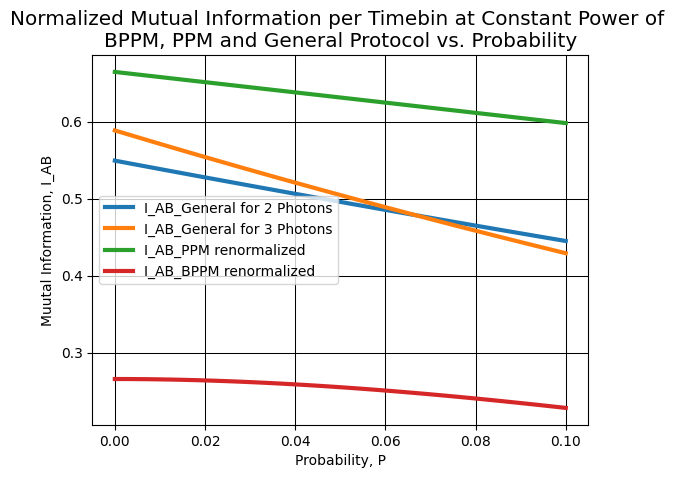

In [20]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_per_Time_Bin_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_per_Time_Bin_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_per_Time_Bin_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_per_Time_Bin_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information per Timebin at Constant Power of \nBPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
# plt.title('I_AB_General for n_General = 2 and n_General = 3\nwith a long title that spans two lines')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Mutual Informatioln per Number of Photon at Constant Power

In [21]:
I_AB_BPPM_per_Photon_list = []
I_AB_PPM_per_Photon_list = []
I_AB_General_n2_per_Photon_list_= []
I_AB_General_n3_per_Photon_list = []

P_list = np.linspace(1e-6,0.999999,101)

In [22]:
I_AB_BPPM_per_Photon_list = []
I_AB_PPM_per_Photon_list = []
I_AB_General_n2_per_Photon_list = []
I_AB_General_n3_per_Photon_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
    n = 5
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_per_Photon_val = I_AB_BPPM_val/ n
    I_AB_BPPM_per_Photon_list.append(I_AB_BPPM_per_Photon_val)

    n_PPM = 1
    M = 5

    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_per_Photon_val = I_AB_PPM_val / n_PPM
    I_AB_PPM_per_Photon_list.append(I_AB_PPM_per_Photon_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)
    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_Photon_val = I_AB_General_val / n_General 
    I_AB_General_n2_per_Photon_list.append(I_AB_General_per_Photon_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_Photon_val = I_AB_General_val / n_General 
    I_AB_General_n3_per_Photon_list.append(I_AB_General_per_Photon_val)

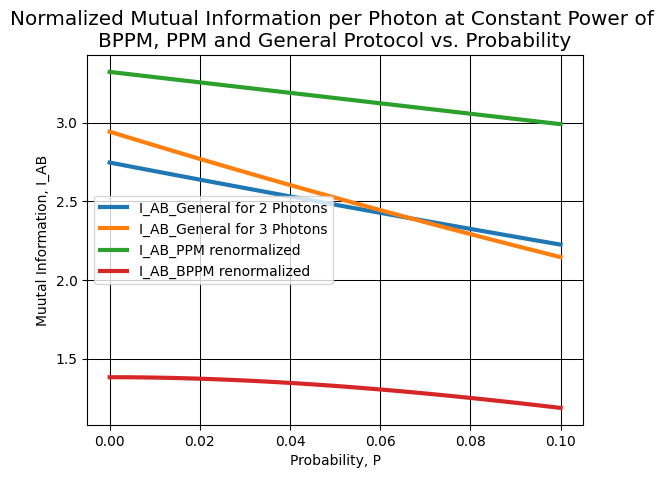

In [23]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_per_Photon_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_per_Photon_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_per_Photon_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_per_Photon_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information per Photon at Constant Power of \nBPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
# plt.title('I_AB_General for n_General = 2 and n_General = 3\nwith a long title that spans two lines')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [24]:
I_AB_BPPM_per_Photon_list = []
I_AB_PPM_per_Photon_list = []
I_AB_General_n2_per_Photon_list = []
I_AB_General_n3_per_Photon_list = []

P_list = np.linspace(1e-6,0.9999999,101)

for P in P_list:
    n = 5
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_per_Photon_val = I_AB_BPPM_val/ n
    I_AB_BPPM_per_Photon_list.append(I_AB_BPPM_per_Photon_val)

    n_PPM = 1
    M = 5

    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_per_Photon_val = I_AB_PPM_val / n_PPM
    I_AB_PPM_per_Photon_list.append(I_AB_PPM_per_Photon_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)
    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_Photon_val = I_AB_General_val / n_General 
    I_AB_General_n2_per_Photon_list.append(I_AB_General_per_Photon_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)

    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)

    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # Mutual Informatioln per Time Bin
    I_AB_General_per_Photon_val = I_AB_General_val / n_General 
    I_AB_General_n3_per_Photon_list.append(I_AB_General_per_Photon_val)


comparing mi per photon and mi per time bin:

Would we expect the mutual information per time bin is similar to the mutual information per photon.

we may expect it, since we use different photon per time bin to maintain the ratio of power the same, 

so they may have the same influence


Becasue we have photon power, we have the relation

time bin is 5 times the photon




HOw the matrix looks like,

constant power, good comparison,
we want constant energy per bit in the system

constant bit per time bin, constant energy per bit

transmit message that minmize the the energy transmission, or transmit the message in short time

the same performance and compare the modulation format


If we want to have error correction, we need to sacrifice something

you may even double the capcity for 0 error 

if having PPM instead

but the quality for small error 

if we rescale all to 1, you can measure the lost / error per source entropy 

then get the quality measure

only see the capcity now, which is not favourable,

because we can transmit more information if there is no error correction

mutual information is the information you contain in the message 

that we see is the number of correct bit you can get through

in order to get this, we need to consider 



if we make more code and double the photon number

the blue one and yellow

at the same power. but higher number of photon 

becasue can happen if we make the codeword 





keep the same energy per bit in 4 cases how mutual information

energy per time bin constant now

then we will get another graph

bit per time bin 

binary modulation OOK may be the best 

highest bit rate but not energy efficient





energy per mutual information bit at zero noise or noise

which is the function or error probability 

mutual information changes



not constant power to look




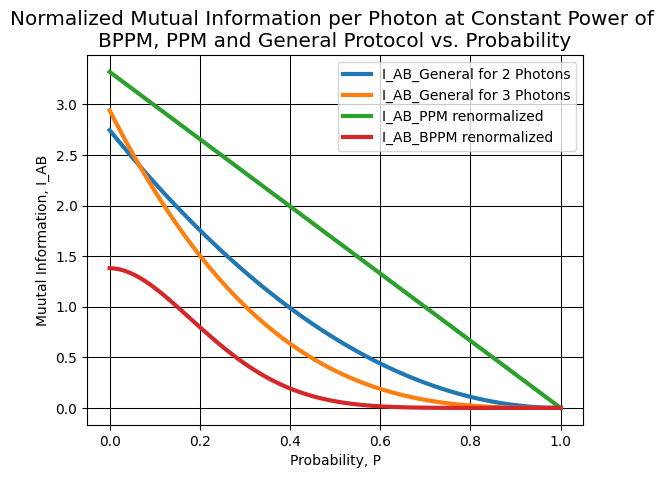

In [25]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_per_Photon_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_per_Photon_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_per_Photon_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_per_Photon_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information per Photon at Constant Power of \nBPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
# plt.title('I_AB_General for n_General = 2 and n_General = 3\nwith a long title that spans two lines')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()

# Note

BPPM
it is expected since there is a price to pay for the, there is a flatness at the beginning for BPPM
It is due to error correction, which is important

What happen when photon is lost in the general case. 
We should look at the lost error.

how should we treat the codeword when there is a loss.

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_AB_General(n_General):
    T_General =  compute_T_General(n_General)
    matrix = np.eye(int(combination(T_General, n_General))) / combination(T_General, n_General)  
    return matrix 

photon from BPPM not like the general case with 2 photons sent
if 1 is received and 1 is lost
do they consider to be detectable but not correctable errors

General case has nothing to do with 1,2,4,7 this kind of encoding

If there is a split of adjacent errors or non-adjacent errors

The above is a diagonal matrix,

2 photons out of 10, put 2 photons in any of the time bin, if lose 1 photon, you still 1
1 photon can still give you some information, but you cannot correct it, becasue you have incomplete information, and you do not have a proper sydrome to correct it

int

def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    # return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))


How can deal with single photon lost error
more photon, then more trouble 

P_AB does not depend on the noise, but how can the whole thing depends on noise?

Where does the noise come from the function?

The matrix is just a constant and does not care about the noise

Compare this with BPPM, actually depends on P

function definition inside another function definition, not a good coding form
There may be a situation sth not defined

PSuccess is always 1 - P_D for diagonal way
if there is chance to confuse codeword
P_AB will work only on diagonal way

absorption error, no added error


# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)


Is there a way to determine if an error is detectable or not

adacjacent, non-adjacent

should be n-2 over r 

keep in track what error is correctable, detectable but not correctable, incorrectly correct the error
error mistaken
only general expression

where we can try the specific case? 

If p happen, then q cannot happen

how many time, add error, excited states, loss error and the corresponding probability

we can correct 1 error, some cases 2 errors, or cannot correct any error, 

PSuccess
different parameter
only detect
(0,0,0)
function

loss or add, loss and add

P_AB depends on the loss 

no confusion error if only the lost in practice
plot, mutual information per time bin, it should be correct 

if we change 

more photons, if there is no decay, not correct it loss information

n = 3, starts higher and loss information faster, decrease faster


how much information you can transfer at different noise level 

mutual information

divide by number of time bin at fixed power

divide by the number of photon

look at a smaller interval p = 0 to p = 0.1 

how is the quality

bit error rate

green an contain more information when P = 0 

if P very close to 0, you will have errors

The red one perseve the bits when it is close to 0 

quality 

quality of the bit

start at the same level

100% loss


lower P value is more realistic, and why? 


cannot convey much information 

it can correct some errors


is it the same consistently



# More Power Ratio
Values matched for BPPM photon number and PPM time bin
<br>5,5 
<br>6,8 
<br>7,11 
<br>8,14 (exact)
<br>9,18 
<br>10,24 (exact)
<br>11,30 (exact)
<br>12,38 (exact)
<br>13,47 (exact)

In [26]:
I_AB_BPPM_list = []
I_AB_PPM_list = []
I_AB_General_n2_list = []
I_AB_General_n3_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
    n = 8
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)
    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_list.append(I_AB_BPPM_val)

    n_PPM = 1
    M = 14

    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   
    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)
    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)
    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_list.append(I_AB_PPM_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)
    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   
    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)
    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)
    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n2_list.append(I_AB_General_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)
    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   
    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)
    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)
    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    I_AB_General_n3_list.append(I_AB_General_per_timebin_val)

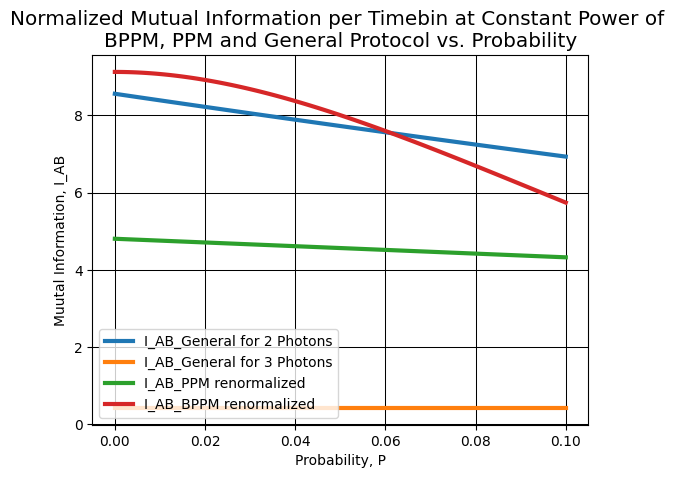

In [27]:
# Plot for n_General = 2
plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information per Timebin at Constant Power of \nBPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
# plt.title('I_AB_General for n_General = 2 and n_General = 3\nwith a long title that spans two lines')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Energy per Mutual information

In [28]:
E_per_I_AB_BPPM_list = []
E_per_I_AB_PPM_list = []
E_per_I_AB_General_n2_list = []
E_per_I_AB_General_n3_list = []

# I_AB_BPPM_per_Time_Bin_list = []
# I_AB_PPM_per_Time_Bin_list = []
# I_AB_General_n2_per_Time_Bin_list = []
# I_AB_General_n3_per_Time_Bin_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
    n = 5
    N_n = compute_N(n) 
    P_D_val = P_D(n,P, 0, l=0,a=0) # P_D(n,P_l,P_a, l=0,a=0)
    P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
    P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
    P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-9, P_AB_BPPM_val)
    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    #I_AB_BPPM_per_Timebin_val = I_AB_BPPM_val/N_n
    #I_AB_BPPM_per_Time_Bin_list.append(I_AB_BPPM_per_Timebin_val)
    E_per_I_AB_BPPM_val = n / I_AB_BPPM_val
    E_per_I_AB_BPPM_list.append(E_per_I_AB_BPPM_val)

    n_PPM = 1
    n_BPPM = 5
    #N_n = compute_N(n) 
    M = compute_M(n_BPPM)
    P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   
    P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)
    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)
    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    # I_AB_PPM_per_timebin_val = I_AB_PPM_val / M
    # I_AB_PPM_per_Time_Bin_list.append(I_AB_PPM_per_timebin_val)
    E_per_I_AB_PPM_val = n / I_AB_PPM_val
    E_per_I_AB_PPM_list.append(E_per_I_AB_PPM_val)

    # n_General = 2
    n_General = 2
    T_General = compute_T_General(n_General)
    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   
    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)
    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    H_AB_General_val = H_AB_General(P_AB_General_val)
    I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
    # # Mutual Informatioln per Time Bin
    # I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    # I_AB_General_n2_per_Time_Bin_list.append(I_AB_General_per_timebin_val)
    E_per_I_AB_General_val = n / I_AB_General_val
    E_per_I_AB_General_n2_list.append(E_per_I_AB_General_val)

    # n_General = 3
    n_General = 3
    T_General = compute_T_General(n_General)
    P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   
    P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
    P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
    P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)
    H_A_General_val = H_A_General(P_AB_General_val)
    H_B_General_val = H_B_General(P_AB_General_val)
    # H_AB_General_val = H_AB_General(P_AB_General_val)
    # I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)

    # # Mutual Informatioln per Time Bin
    # I_AB_General_per_timebin_val = I_AB_General_val / T_General 
    # I_AB_General_n3_per_Time_Bin_list.append(I_AB_General_per_timebin_val)
    E_per_I_AB_General_val = n / I_AB_General_val
    E_per_I_AB_General_n3_list.append(E_per_I_AB_General_val)

/var/folders/nd/4tv7bl7d4ys_1zhq177b1_qr0000gn/T/ipykernel_1680/2723715679.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  E_per_I_AB_BPPM_val = n / I_AB_BPPM_val


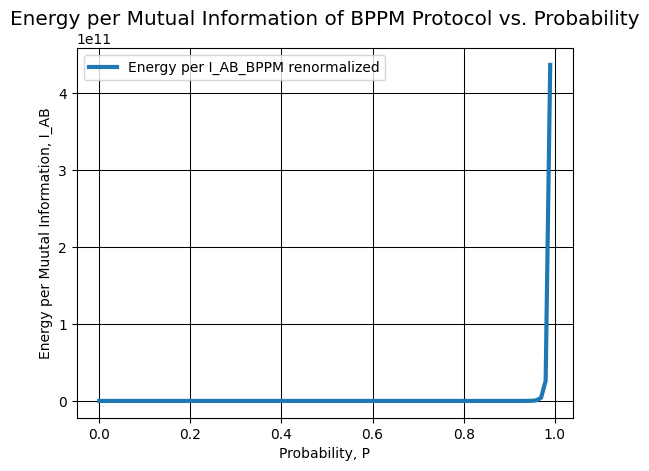

In [29]:
# Plot for n_General = 2
# plt.plot(P_list, E_per_I_AB_General_n2_list, linewidth=3, label='Energy per I_AB_General for 2 Photons')
# Plot for n_General = 3
# plt.plot(P_list, E_per_I_AB_General_n3_list, linewidth=3, label='Energy per I_AB_General for 3 Photons')

# plt.plot(P_list,  E_per_I_AB_PPM_list, label='Energy per I_AB_PPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list,  E_per_I_AB_BPPM_list, label='Energy per I_AB_BPPM renormalized', linewidth=3, alpha=1)


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Energy per Muutal Information, I_AB')
# plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
plt.title('Energy per Mutual Information of BPPM Protocol vs. Probability', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Draft

In [30]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_General_list, label='I_AB_General', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM', linewidth=3, color='g', alpha=1)
plt.plot(P_list, I_AB_list, label='I_AB_BPPM_normalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

NameError: name 'I_AB_General_list' is not defined

In [ ]:
combination(T_General, n_General)

In [ ]:
P_AB_General(n_General), len(P_AB_General(n_General))

In [ ]:
P_AB_General_val = P_AB_General(n_General)
# P_AB_General_val = np.array(P_AB_General_val)
# P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

In [ ]:
H_A_General_val = H_A_General(P_AB_General_val)

# OOK

It will in average use k=n/2 photons per symbol
 OOKWays = (2)**series[n-1]    number of symbols m in PPM will be m=2^n
 OOKbps = math.log2(OOKWays)   The number of bits (the information content per symbol) will be b=log2(m)=n
 OOKbpp = 2 # bit per photon
 OOKbpt = 1 # bit per time bin


In [ ]:
def compute_T_OOK(n_OOK):
  # def agen(): # generator of terms
  #     aset, sset, k = set(), set(), 0
  #     while True:
  #         k += 1
  #         while any(k+an in sset for an in aset): k += 1
  #         yield k; sset.update(k+an for an in aset); aset.add(k)
  # a = list(islice(agen(), 100))
  # photon = list(map(lambda v: v-1, a))
  # compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  T_OOK = 2 * n_OOK # int(len(list(itertools.permutations(range(n)))))
  return T_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_OOK(n_OOK, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n_OOK))) / (math.factorial((int(n_OOK-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, P_a, a):
    T_OOK = compute_T_OOK(n_OOK)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_OOK - n, a) * (P_a)**a * (1 - P_a)**(T_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err(n_OOK, P_l, P_a,l,a):
  return Loss_Distribute(n_OOK,P_l,l) * Add_Distribute(n_OOK,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_OOK(n_OOK,P_l,P_a,l,a):
  return P_err(n_OOK,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_OOK(n_OOK,P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK(n_OOK,P_l,P_a, l=0, a=0)

def P_AB_OOK(n_OOK, P_D_OOK):
    T_OOK =  compute_T_OOK(n_OOK) #int(len(list(itertools.permutations(range(n)))))
    # P_AB_OOK = [(P ** i) * ((1 - P) ** (n - 1 - i)) for i in range(n)]
    # P_AB_OOK = [(1-P_D_OOK) for i in range(M)]
    matrix = np.eye(T_OOK) * 1/T_OOK  #[[1/M * P_AB_[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

def P_A_OOK(P_AB_OOK, P_D_OOK):
    if P_D == 1:
        return [1 for row in P_AB_OOK]
    else:
        return [sum(row) for row in P_AB_OOK] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK(P_AB_OOK, P_D_OOK):
    if P_D == 1:
        return [1 for col in zip(*P_AB_OOK)]
    else:
        return [sum(col) for col in zip(*P_AB_OOK)]
def H_A_OOK(P_AB_OOK):
     P_A_OOK = np.sum(P_AB_OOK, axis=1)
     H_a_OOK = np.sum(-P_A_OOK * np.log2(np.where(P_A_OOK == 0, 1, P_A_OOK)))
     return H_a_OOK

def H_B_OOK(P_AB_OOK):
     P_B_OOK = np.sum(P_AB_OOK, axis=0)
     H_b_OOK = np.sum(-P_B_OOK * np.log2(np.where(P_B_OOK == 0, 1, P_B_OOK)))
     return H_b_OOK

def H_AB_OOK(P_AB_OOK):
    P_AB_OOK = np.where(P_AB_OOK == 0, 1e-9, P_AB_OOK)  # replace zero values with 1e-9
    H_OOK = -(P_AB_OOK * np.log2(P_AB_OOK)).sum()
    return H_OOK

def I_AB_OOK(H_A_OOK, H_B_OOK, H_AB_OOK, P_D_OOK):
    if np.isnan(H_AB_OOK):
        return 0
    else:
        return ((H_A_OOK + H_B_OOK - H_AB_OOK)) * (1-P_D_OOK)

I_AB_OOK_list = []

P_list = np.linspace(1e-6,0.999999,101)

for P in P_list:
  n_OOK = 23
  #N_n = compute_N(n) 
  T_OOK = compute_T_OOK(n_OOK)

  P_D_OOK_val = P_D_OOK(n,P, 0, l=0,a=0)   

  P_AB_OOK_val = P_AB_OOK(M, P_D_OOK_val) # P_AB_OOK(n, P)
  P_AB_OOK_val = np.array(P_AB_OOK_val) # convert list of lists to numpy array
  P_AB_OOK_val = np.where(P_AB_OOK_val <= 0, 1e-9, P_AB_OOK_val)

  H_A_OOK_val = H_A_OOK(P_AB_OOK_val)
  H_B_OOK_val = H_B_OOK(P_AB_OOK_val)
  H_AB_OOK_val = H_AB_OOK(P_AB_OOK_val)

  I_AB_OOK_val = I_AB_OOK(H_A_OOK_val, H_B_OOK_val, H_AB_OOK_val, P_D_OOK_val)
  I_AB_OOK_list.append(I_AB_OOK_val)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
axs[0].plot(P_list, I_AB_OOK_list, label='I_AB_OOK renormalized', linewidth=3, color='r', alpha=1)
axs[0].legend(title='Legend', loc='upper right', fontsize='large')
axs[0].grid(color='k', linestyle='-', linewidth=0.75)
axs[0].set_xlabel('Probability, P', fontsize='large')
axs[0].set_ylabel('Mutual Information, I', fontsize='large')
axs[0].set_title('Renormalized Mutual Information of OOK vs. Probability', fontsize='x-large')
axs[0].set_facecolor('white')

# plot on the right
axs[1].plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
axs[1].legend(title='Legend', loc='upper right', fontsize='large')
axs[1].grid(color='k', linestyle='-', linewidth=0.75)
axs[1].set_xlabel('Probability, P', fontsize='large')
axs[1].set_ylabel('Mutual Information, I', fontsize='large')
axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
axs[1].set_facecolor('white')

plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(25, 10))
P_list = np.linspace(1e-6,0.999999,101)

# plot on the left
plt.plot(P_list, I_AB_OOK_list, label='I_AB_OOK renormalized', linewidth=3, color='r', alpha=1)
plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)

plt.legend(title='Legend', loc='upper right', fontsize='large')
plt.grid(color='k', linestyle='-', linewidth=0.75)
plt.xlabel('Probability, P', fontsize='large')
plt.ylabel('Mutual Information, I', fontsize='large')
plt.title('Renormalized Mutual Information of BPPM and OOK vs. Probability', fontsize='x-large')
#plt.facecolor('white')

# # plot on the right
# plt.plot(P_list, I_AB_list, label='I_AB renormalized', linewidth=3, color='navy', alpha=1)
# axs[1].legend(title='Legend', loc='upper right', fontsize='large')
# axs[1].grid(color='k', linestyle='-', linewidth=0.75)
# axs[1].set_xlabel('Probability, P', fontsize='large')
# axs[1].set_ylabel('Mutual Information, I', fontsize='large')
# axs[1].set_title('Renormalized Mutual Information of BPPM vs. Probability', fontsize='x-large')
# axs[1].set_facecolor('white')
#plt.figure(figsize=(10, 10))
plt.figure().set_figwidth(15)
plt.show()

## OOk